In [1]:
%pylab inline

import seaborn as sns
import numpy as np

from sigvisa.plotting.event_heatmap import EventHeatmap
from sigvisa.source.event import get_event
from sigvisa import Sigvisa

Populating the interactive namespace from numpy and matplotlib


In [65]:
from sigvisa.signals.io import load_event_station_chan
from sigvisa.infer.template_xc import fastxc

w1 = load_event_station_chan(3375230, "ELK", "BHZ", pre_s=5, phases=["Pg", "Lg"], post_s=50)
wf1 = w1.filter("freq_0.8_4.5")

w2 = load_event_station_chan(3375263, "ELK", "BHZ", pre_s=5, phases=["Pg", "Lg"], post_s=50)
wf2 = w2.filter("freq_0.8_4.5")



1203605196.07 1203605258.16
1203616826.69 1203616888.75


In [66]:

srate=40
sidx = 22*srate
extracted = wf1.data.data[sidx:52*srate]


xc = fastxc(extracted, wf2.data.data)
print np.max(xc)


0.907946964333


[]

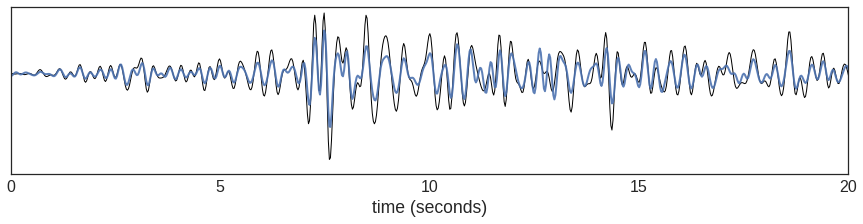

In [68]:
sns.set_style("white")
sns.set_context("paper", font_scale=2.0)

align_idx = np.argmax(xc) - sidx
align_s = align_idx / float(srate)

start_s = 24

t2 = np.linspace(-start_s, len(w2.data)/40.0 - start_s, len(w2.data))
t1 = np.linspace(-start_s + align_s, len(w1.data)/40.0 - start_s + align_s, len(w1.data))


f = plt.figure(figsize=(15, 3))
ax = f.add_subplot(111)
ax.plot(t1, wf1.data, lw=1, alpha=1, label="3375230", color="black")
ax.plot(t2, wf2.data, lw=2, alpha=0.9, label="3375263", ls="-")
ax.set_xlim([0, 20])
ax.set_xlabel("time (seconds)")
ax.set_yticks([])
#ax.legend(loc="upper right")

In [44]:
from sigvisa.graph.load_sigvisa_graph import load_sg_from_db_fit
fitid = 267971 #258192

sg = load_sg_from_db_fit(fitid)
wave_node = list(sg.station_waves.values()[0])[0]
obs_wave = wave_node.get_wave()
wave_node.unfix_value()
wave_node._parent_values()

warning, no hparam prior specified for mult_wiggle_std , using dummy
setting template 1 Lg to {'coda_decay': -2.278625, 'peak_offset': 0.710849, 'coda_height': 7.970643, 'arrival_time': 1203620817.863517, 'peak_decay': -2.301421}
setting template 1 Pg to {'coda_decay': -3.682136, 'peak_offset': 0.128212, 'coda_height': 6.272459, 'arrival_time': 1203620812.1624, 'peak_decay': -2.983745}


{'1;Lg;ELK;:;:;arrival_time': 1203620817.863517,
 '1;Lg;ELK;BHZ;freq_0.8_4.5;coda_decay': -2.278625,
 '1;Lg;ELK;BHZ;freq_0.8_4.5;coda_height': 7.970642999999999,
 '1;Lg;ELK;BHZ;freq_0.8_4.5;peak_decay': -2.301421,
 '1;Lg;ELK;BHZ;freq_0.8_4.5;peak_offset': 0.710849,
 '1;Pg;ELK;:;:;arrival_time': 1203620812.1624,
 '1;Pg;ELK;BHZ;freq_0.8_4.5;coda_decay': -3.682136,
 '1;Pg;ELK;BHZ;freq_0.8_4.5;coda_height': 6.2724589999999996,
 '1;Pg;ELK;BHZ;freq_0.8_4.5;peak_decay': -2.983745,
 '1;Pg;ELK;BHZ;freq_0.8_4.5;peak_offset': 0.128212,
 '1;depth': 12.5,
 '1;lat': 41.124099999999999,
 '1;lon': -114.8926,
 '1;mb': 2.7000000000000002,
 'nm_ELK_BHZ_freq_0.8_4.5_1203620722.5': <sigvisa.models.noise.armodel.model.ARModel at 0x7f6c048eca10>}

In [54]:
from sigvisa.signals.io import *
#pred_wave = wave_node.assem_env() + wave_node.nm_env.c
#pred_wave = Waveform(pred_wave, segment_stats=wave_node.mw.segment_stats.copy(), my_stats=wave_node.mw.my_stats.copy())
#pred_wave.mask = obs_wave.data.mask

vv = wave_node.tssm.obs_var(npts)

srate = wave_node.srate
stime = wave_node.st
npts = wave_node.npts
timevals = np.arange(stime, stime + npts / srate, 1.0 / srate)[0:npts]



In [55]:
print len(vv)
print len(timevals-aetime)
print npts

4748
4748
4748


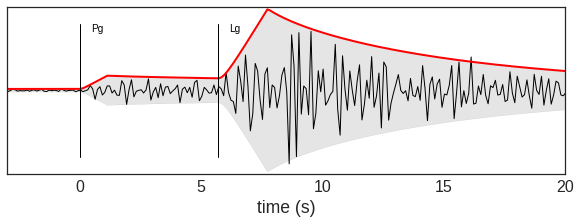

In [64]:
from sigvisa.plotting.plot import subplot_waveform, plot_pred_atimes

f = plt.figure(figsize=(10, 3))
ax = f.add_subplot(111)

aetime = 1203620812.1624
#aetime = 1168129664.5415621

ax.plot(timevals-aetime, obs_wave.data, color="black", linewidth=1, alpha = 1)
#subplot_waveform(pred_wave, ax, color="green", linewidth=1, alpha = 1)

ax.plot(timevals-aetime, 2*np.sqrt(vv), color="red", linewidth=2, alpha = 1)
ax.fill_between(timevals-aetime, -2*np.sqrt(vv),
                          2*np.sqrt(vv), facecolor="gray", alpha=0.2)

ax.set_xlim([-3, 20])
ax.set_xlabel("time (s)")
ax.set_ylabel("")
ax.set_yticks([])
#ax.set_ylim([ymin, ymax])

xmin = aetime - 3
xmax = aetime + 20
atimes = dict([("%s" % (phase), wave_node.get_template_params_for_arrival(eid=eid, phase=phase)[0]['arrival_time']) for (eid, phase) in wave_node.arrivals()])
atimes = dict([(k, atime-aetime) for (k, atime) in atimes.items() if xmin < atime < xmax ])

atime_kwargs = {
    'alpha': 1.0,
    'bottom_rel': 0.1,
    'top_rel': 0.9
    }
plot_pred_atimes(dict(atimes), obs_wave, axes=ax, color="black", **atime_kwargs)
